In [1]:
library(data.table)
library(ggplot2)
library(tidyr)
library(grid)
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
#some nicer themes and useful functions
theme_set(theme_bw(base_size=10))
theme_update(axis.text=element_text(color="black"), panel.grid.minor = element_blank(),panel.background = element_rect(fill = "white"))
rotate_labels=function(angle=60,vjust=1,hjust=1){return(theme(axis.text.x = element_text(angle = angle, vjust = vjust,hjust=hjust)))}

In [3]:
#specify where to save outputs
out="/ahg/regevdata/projects/PediatricCancer/results/2021_04_15_powerEstimator/"
dir.create(out,recursive = TRUE)

Warning message in dir.create(out, recursive = TRUE):
"'/ahg/regevdata/projects/PediatricCancer/results/2021_04_15_powerEstimator' already exists"


In [4]:
#Load a table that contains a cell type annotation for each cell. This is usually the seurat meta or scanpy obs slot saved as tsv (or similar).
#annot=fread("/ahg/regevdata/projects/PediatricCancer/results/2020_09_15_neuroblastoma_inferCNV/metadata_allcells_allnuclei_addCNV_annotate.csv")
annot=fread("/ahg/regevdata/projects/PediatricCancer/results/2021_04_28_neuroblastoma_slideseq//metadata_allcells_allnuclei_addCNV_annotate_refine_slideseq_samples.csv")  # from neuroblastoma_slideseq_common_reference.Rmd

setnames(annot, "orig.ident", "name")
setnames(annot, "V1", "cellid")
setnames(annot, "annotate_refine_1", "cell_type")
#setnames(annot, "SingleR.cluster.labels", "cell_type")

# Group all malignant cell types under a single label, Malignant
annot$cell_type <- dplyr::recode(annot$cell_type, "cycling sympathoblast" = "Malignant", "sympathoblast" = "Malignant", "SCP" = "Malignant")
table(annot$cell_type)

head(annot)
colnames(annot)


     B cell Endothelial Erythrocyte   Malignant     Myeloid      Stroma 
       6840       44680         261      344124       36498       52346 
     T cell        Zona 
      31510       14290 

cellid,name,nCount_RNA,nFeature_RNA,nGene,Channel,Replicate,Condition,nUMI,percent_mito,...,condition,doublet,doubletscore,nRead_RNA,nHK_RNA,SingleR.cell.labels,SingleR.cluster.labels,conos_clusters,annotate_coarse,cell_type
<chr>,<chr>,<int>,<int>,<int>,<chr>,<int>,<chr>,<int>,<dbl>,...,<chr>,<lgl>,<dbl>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>
HTAPP-312-SMP-901_fresh-T1_channel1-TTTGTCATCTATCGCC,HTAPP-312-SMP-901,36277,6161,6161,HTAPP-312-SMP-901_fresh-T1_channel1,1,fresh-T1,36277,4.484935,...,cell,FALSE,0.1578947,5548,83,Neurons,Neurons,1,Stromal_Malignant,Malignant
HTAPP-312-SMP-901_fresh-T1_channel1-AACTCCCTCACGCGGT,HTAPP-312-SMP-901,34855,5889,5889,HTAPP-312-SMP-901_fresh-T1_channel1,1,fresh-T1,34855,4.010902,...,cell,FALSE,0.1923331,9633,83,Neurons,Neurons,1,Stromal_Malignant,Malignant
HTAPP-312-SMP-901_fresh-T1_channel1-GCTGCTTGTGTAATGA,HTAPP-312-SMP-901,33654,5906,5906,HTAPP-312-SMP-901_fresh-T1_channel1,1,fresh-T1,33654,5.853688,...,cell,FALSE,0.2067511,4701,82,Neurons,Neurons,1,Stromal_Malignant,Malignant
HTAPP-312-SMP-901_fresh-T1_channel1-CTCAGAAAGTGTCTCA,HTAPP-312-SMP-901,32768,5828,5828,HTAPP-312-SMP-901_fresh-T1_channel1,1,fresh-T1,32768,6.771851,...,cell,FALSE,0.2419355,5403,83,Neurons,Neurons,1,Stromal_Malignant,Malignant
HTAPP-312-SMP-901_fresh-T1_channel1-ACGCCGAAGCAGCGTA,HTAPP-312-SMP-901,32089,5156,5156,HTAPP-312-SMP-901_fresh-T1_channel1,1,fresh-T1,32089,5.082739,...,cell,FALSE,0.1191432,1298,82,Neurons,Neurons,1,Stromal_Malignant,Malignant
HTAPP-312-SMP-901_fresh-T1_channel1-TTCGGTCTCAAGAAGT,HTAPP-312-SMP-901,30704,5908,5908,HTAPP-312-SMP-901_fresh-T1_channel1,1,fresh-T1,30704,4.810448,...,cell,FALSE,0.1795511,8978,86,Neurons,Neurons,1,Stromal_Malignant,Malignant


[1] "cellid"                 "name"                   "nCount_RNA"            
 [4] "nFeature_RNA"           "nGene"                  "Channel"               
 [7] "Replicate"              "Condition"              "nUMI"                  
[10] "percent_mito"           "scale"                  "louvain_labels"        
[13] "leiden_labels"          "chemistry"              "condition"             
[16] "doublet"                "doubletscore"           "nRead_RNA"             
[19] "nHK_RNA"                "SingleR.cell.labels"    "SingleR.cluster.labels"
[22] "conos_clusters"         "annotate_coarse"        "cell_type"

In [5]:
annot$cell_type <- dplyr::recode(annot$cell_type, "cycling sympathoblast" = "Malignant", "sympathoblast" = "Malignant", "SCP" = "Malignant")
table(annot$cell_type)


     B cell Endothelial Erythrocyte   Malignant     Myeloid      Stroma 
       6840       44680         261      344124       36498       52346 
     T cell        Zona 
      31510       14290 

In [6]:
# get some stats on the cohort
cat(sort(unique(annot$name)))
cat('\n')
cat(unique(annot$ccpm_id))
annot[,.(Nsamples=length(unique(name))),by=condition]
annot[,.(Ncells=.N),by=c("condition")]

HTAPP-100-SMP-1 HTAPP-102-SMP-11 HTAPP-114-SMP-21 HTAPP-116-SMP-31 HTAPP-120-SMP-41 HTAPP-123-SMP-51 HTAPP-124-SMP-61 HTAPP-125-SMP-71 HTAPP-126-SMP-81 HTAPP-130-SMP-91 HTAPP-136-SMP-102 HTAPP-141-SMP-111 HTAPP-141-SMP-119 HTAPP-145-SMP-121 HTAPP-146-SMP-131 HTAPP-148-SMP-141 HTAPP-155-SMP-151 HTAPP-159-SMP-171 HTAPP-163-SMP-181 HTAPP-164-SMP-191 HTAPP-166-SMP-201 HTAPP-167-SMP-211 HTAPP-168-SMP-221 HTAPP-171-SMP-231 HTAPP-184-SMP-241 HTAPP-194-SMP-251 HTAPP-195-SMP-261 HTAPP-196-SMP-271 HTAPP-198-SMP-281 HTAPP-204-SMP-6601 HTAPP-233-SMP-361 HTAPP-244-SMP-451 HTAPP-312-SMP-901 HTAPP-312-SMP-902 HTAPP-352-SMP-1231 HTAPP-376-SMP-1381 HTAPP-396-SMP-1621 HTAPP-437-SMP-1861 HTAPP-527-SMP-6767 HTAPP-621-SMP-3181 HTAPP-656-SMP-3481_TST HTAPP-656-SMP-3481_fresh HTAPP-672-SMP-8509 HTAPP-683-SMP-6769 HTAPP-756-SMP-6779 HTAPP-766-SMP-6780 HTAPP-768-SMP-6781 HTAPP-797-SMP-4232 HTAPP-800-SMP-6783 HTAPP-800-SMP-6784 HTAPP-803-SMP-6786 HTAPP-811-SMP-6832 HTAPP-811-SMP-6833 HTAPP-811-SMP-6834 HTAPP-81

condition,Nsamples
<chr>,<int>
cell,13
nucleus,44


condition,Ncells
<chr>,<int>
cell,85052
nucleus,445497


### 0 Preparation 

In [7]:
#Reduce the annotation table to only relevant columns and calculate per-sample cell type numbers.
#Minimum requirement: sample name (here "name") and annotated cell type of a cell (here "cell_type"). 
#All other columns are covariates by which one might want to subset the data
#cell_counts=annot[,.(N_cells=.N),by=c("name","cell_type","condition","site_biopsy","ER_biopsy","PR_biopsy","HER2_biopsy")]
cell_counts=annot[,.(N_cells=.N),by=c("name", "cell_type", "condition")]
#cell_counts=annot[,.(N_cells=.N),by=c("name", "SingleR.cluster.labels", "Channel", "condition")]
head(cell_counts)

name,cell_type,condition,N_cells
<chr>,<chr>,<chr>,<int>
HTAPP-312-SMP-901,Malignant,cell,4992
HTAPP-312-SMP-901,Myeloid,cell,62
HTAPP-312-SMP-901,T cell,cell,19
HTAPP-656-SMP-3481_fresh,Zona,cell,123
HTAPP-656-SMP-3481_fresh,Endothelial,cell,370
HTAPP-656-SMP-3481_fresh,Myeloid,cell,465


### 1 Perfom the core of the analyis step by step on one set of sampels

In [8]:
#Function to plot beta distribution densities given priors stored in dt
plot_density=function(dt){
    l=list()
    for (i in 1:nrow(dt)){
    x=seq(from = 0,to = 1,by = 0.01)
    tc_dat=data.table(Frequency=x,Density=dbeta(x=x,shape1=1+dt[i,]$Ntc,shape2=1+dt[i,]$Nntc))
    pl=ggplot(tc_dat,aes(Frequency,Density))+geom_line()+geom_vline(xintercept = dt[i,]$ftc,col="red")+ggtitle(dt[i,]$name)+theme(plot.title = element_text(size = 8))
    l[[i]]=pl
    }
    return(l)
}

#### 1.1 Setup

In [9]:
#subset
sub=cell_counts[condition=="cell"]
#target cell type
tc="T cell"

In [10]:
minC=50 #minimum number of cells from cell type of interest required
minS=5 #minimum number of samples with minC cells (referred to as "positive samples")
conf=0.95 #required confidence level of prediction
maxNc=8000 #maximum number of cells that can be sampled per sample
n=5 #number of samples to be included in the training set

In [11]:
# split in train and test samples
set.seed(42)
train_samples=sample(unique(sub$name),size=n,replace=FALSE)
train=sub[name%in%train_samples]
test=sub[!name%in%train_samples]

#### 1.2 Analysis

In [12]:
# per sample caluclate number of target cells and number of non-target cells
train_c=train[,.(Ntc=N_cells[cell_type==tc],Nntc=sum(N_cells[cell_type!=tc])),by="name"]
train_c[is.na(train_c)]=0

In [13]:
# target cell type fraction at selcted confidence level
train_c[,ftc:=qbeta(p=c(1-conf),shape1=1+Ntc,shape2=1+Nntc),by=name]
# probability of being a sample with enough cells of the target cell type
train_c[,ptc:=mean(pbinom(minC-1,maxNc,prob = rbeta(1000,shape1 =1+Ntc ,shape2 = 1+Nntc),lower.tail = FALSE)),by=name]
# number of cells needed at selected confidence level (basis to estimate minimum number of cells per sample that need to be sampled)
train_c[,Nc:=minC/ftc,]
train_c

name,Ntc,Nntc,ftc,ptc,Nc
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
HTAPP-312-SMP-901,19,5054,0.00261375,0.03253477,19129.6045
HTAPP-797-SMP-4232,2882,7733,0.26447063,1.00000000,189.0569
HTAPP-813-SMP-6848,106,6570,0.01358063,0.99999999,3681.7155
HTAPP-164-SMP-191,130,2650,0.04067379,1.00000000,1229.2928
HTAPP-931-SMP-7448,90,3146,0.02349849,1.00000000,2127.7962


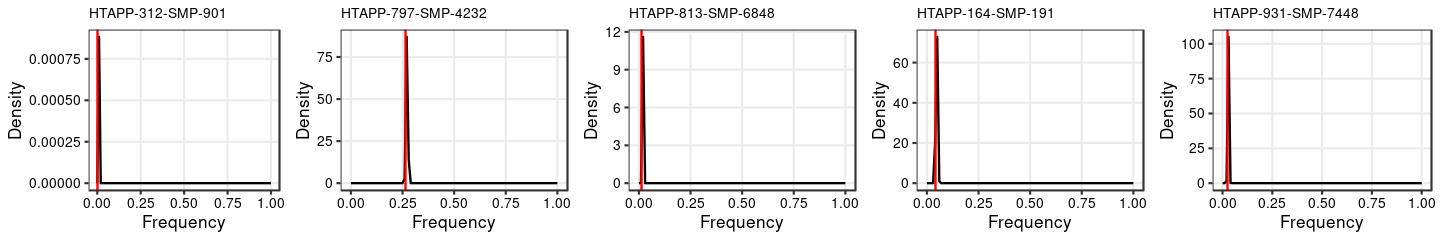

In [14]:
# plot target cell type frequency distribution for each sample.
#Indicated in red is the frequency at which the probability of observing a higher frequency is the confidence level (conf).
options(repr.plot.width = 12, repr.plot.height =2)
pl=plot_density(train_c)
cowplot::plot_grid(plotlist = pl,ncol=5)

In [15]:
# calculate deiscrete and continuous number of samples with (positive) and without (negative) enough cells of the target cell type 
train_s=train_c[,.(Ntc=sum(Nc<=maxNc),Nntc=sum(Nc>maxNc),ftc_c=sum(ptc),ftc_nc=sum(1-ptc))]
train_s[,ftc:=qbeta(p=c(1-conf),shape1=1+Ntc,shape2=1+Nntc)] # discrete fraction of positive samples
train_s[,ftc_cont:=qbeta(p=c(1-conf),shape1=1+ftc_c,shape2=1+ftc_nc)] #continuous fraction of discrete samples
#Rough estimates for the number of smaples needed
train_s[,Nc:=minS/ftc,] #discrete estimate
train_s[,Nc_cont:=minS/ftc_cont,] #continuous estimate
train_s[,Nc_low:=minS/qbeta(p=c(1-conf),shape1=1+Ntc+1,shape2=1+Nntc-1),] #discrete estimate if one more sample was positive
train_s[,Nc_high:=minS/qbeta(p=c(1-conf),shape1=1+Ntc-1,shape2=1+Nntc+1),] #discrete estimate if one more sample was positive

# Adjust the continuous estimate such that averaged across 1000 sampling experiments the desired probability of success (conf) is reached. 
#--> Nc_ref is the recommended number of samples.
train_s[,Nc_ref:=ceiling(Nc_cont),]
train_s[,post_conf:=mean(pbinom(minS-1,Nc_ref,prob = rbeta(1000,shape1 =1+ftc_c ,shape2 = 1+ftc_nc),lower.tail = FALSE))]
stopifnot(train_s$post_conf<conf)
while (train_s$post_conf<conf){
    train_s[,Nc_ref:=Nc_ref+1,]
    train_s[,post_conf:=mean(pbinom(minS-1,Nc_ref,prob = rbeta(1000,shape1 =1+ftc_c ,shape2 = 1+ftc_nc),lower.tail = FALSE))]
}

train_s

In [16]:
train_s

Ntc,Nntc,ftc_c,ftc_nc,ftc,ftc_cont,Nc,Nc_cont,Nc_low,Nc_high,Nc_ref,post_conf
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,1,4.032535,0.9674652,0.4181966,0.4235451,11.9561,11.80512,8.237745,18.42718,13,0.9560968


In [17]:
#refine maxNc (number of cells profiled per sample) such that the minimum number of cells per sample can be recommended that retains the same result
Nc_pass=train_c$Nc[train_c$Nc<=maxNc]
if (length(Nc_pass)>0){
   maxNc_re=max(Nc_pass) 
}else{
    maxNc_re=maxNc
}
maxNc_re

[1] 3681.716

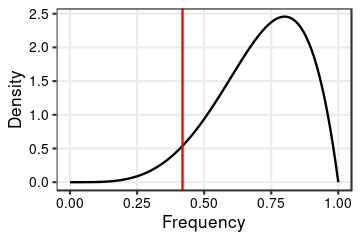

In [18]:
# plot the positive sample frequency distribution. 
#Indicated in red is the frequency at which the probability of observing a higher frequency is the confidence level (conf).
options(repr.plot.width = 3, repr.plot.height =2)
pl=plot_density(train_s)
cowplot::plot_grid(plotlist = pl,ncol=1)

In [19]:
#Calculate probability of success (p) (as defined in the setup) in dependence of the number of profiled samples/patients (size)
fs=data.table(f=seq(0,1,0.1))
fs[,d:=dbeta(x=f,shape1=1+train_s$ftc_c,shape2=1+train_s$ftc_nc)]

fs_screen=data.table()
for (size in c(1:100)){
    tmp=copy(fs)
    tmp[,p:=pbinom(q=minS-1,size = size,prob = f,lower.tail = FALSE),by=1:nrow(tmp)]
    tmp[,size:=size,]
    fs_screen=rbindlist(list(fs_screen,tmp))
}
ps=fs_screen[,.(p=sum(p*d)/sum(d)),by=size]

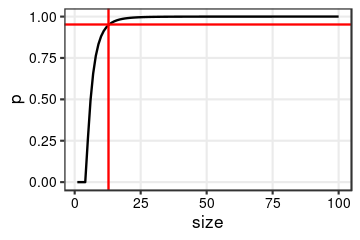

In [20]:
options(repr.plot.width = 3, repr.plot.height =2)
ggplot(ps,aes(x=size,y=p))+geom_line()+geom_vline(xintercept = ceiling(train_s$Nc_ref),col="red")+geom_hline(yintercept = conf,col="red")

In [21]:
#Check the number of positive samples in the test set as "validation". In this case prediction holds true because all test samples happen to be positive. 
#Not really relevant, because the is no statistic. Proper validation needs sampling etc. and is included below.
test[cell_type==tc]

name,cell_type,condition,N_cells
<chr>,<chr>,<chr>,<int>
HTAPP-656-SMP-3481_fresh,T cell,cell,2063
HTAPP-312-SMP-902,T cell,cell,626
HTAPP-672-SMP-8509,T cell,cell,253
HTAPP-159-SMP-171,T cell,cell,29
HTAPP-163-SMP-181,T cell,cell,865
HTAPP-166-SMP-201,T cell,cell,308
HTAPP-167-SMP-211,T cell,cell,553
HTAPP-168-SMP-221,T cell,cell,4278


### 2 Comprehensive assessment and validation with different settings and parameters

#### 2.1 A function to predict and validate the number of samples that need to be profiled in order to fulfil the specified requirements (used in all subsequent steps)

In [22]:
# This function is used as the core of all subsequent analysis and streamlines the step-wise process from section 1. 
#Additionnally it provides the possibility for within and cross-sample validation.
#Parameters:
#sub - Subset of the data to use for the analysis. (dataTable where each row denotes the number of cells of a given cell type in a given sample: name|cell_type|N_cells)
#tc - Target cell type (cell type of which a certain number of cells (minC) needs to be detected in a certain number of samples (minS))
#prior_sf - Prior expectation of the fraction of positive samples (range: 0-1)
#weight - The (hypothetical) number of samples the prior_sf estimate is based on (How sure are you your prior is correct?). The higher, the more influence prior_sf gets compared to what is seen in the data. Set to 0 to not use a prior.
#sample - number of samples used to for training/predicting. Must be smaller than the total number of samples available in the dataset.
#sample_same - If TRUE, use the same number of samples in the test set as are in the training set (sample). If FALSE, use all samples that are not in the training set.
#seed - Random seed for sample selecetion.

#----------Specify requirements here-------------------------------------------------------
#minC - Minimum number of cells from cell type of interest required
#minS - Minimum number of samples with minC cells (referred to as "positive samples")
#conf - Required confidence level of prediction
#maxNc - Maximum number of cells that can be sampled per sample
#------------------------------------------------------------------------------------------
#maxS - Maximum number of samples to be considered for the success-probability plot.
#max_cross - Number of random sample samplings ("cross-validation" loops)
#same - If TRUE, do validation using samplings from the traing-set distribution. If FALSE, do validation using samplings from the test-set (unseen samples) distribution.
#do.test - If TRUE, perfom validation. If FALSE, no validation is run (saves time).
#progress - If TRUE, show progress.


#get_sampleN=function(sub,tc="T",prior_sf=0.5,weight=0,sample=5,sample_same=FALSE,seed=42,minC=50,minS=5,conf=0.95,maxNc=8000,maxS=100,max_cross=100,same=FALSE,do.test=FALSE,progress=TRUE){
get_sampleN=function(sub,prior_sf=0.5,weight=0,sample=5,sample_same=FALSE,seed=42,minC=50,minS=5,conf=0.95,maxNc=8000,maxS=100,max_cross=100,same=FALSE,do.test=FALSE,progress=FALSE, tc){
    
    #Set up beta distribution parameters
    sa=1+prior_sf*weight
    sb=1+(1-prior_sf)*weight
    
    
    #set up train and test sample groupings
    all_samples=unique(sub$name)
    set.seed(seed)

    if (choose(k = sample,n=length(all_samples))>200000){
        split=list()
        for (i in c(1:max_cross)){
            split[[i]]=sample(all_samples,sample,replace = FALSE)}  
    }else{
        comb_mat=combn(all_samples,sample)
        split=as.list(as.data.frame(comb_mat[,sample(ncol(comb_mat),min(c(ncol(comb_mat),max_cross)),replace = FALSE),drop=FALSE],stringsAsFactors = FALSE))}

    #loop through the sample groupings
    res=data.table()
    ps=data.table()
    test_res=data.table()
    
    for (i in 1:length(split)){
        train_samples=split[[i]]    
        train=sub[name%in%train_samples]
        if (same==FALSE){
            if (sample_same==FALSE){
                test=sub[!name%in%train_samples]
            }else{
                test=sub[name%in%sample(unique(name)[!unique(name)%in%train_samples],sample)]}
        }else{
            test=train
        }
        
        #train calculations    
        train_c=train[,.(Ntc=N_cells[cell_type==tc],Nntc=sum(N_cells[cell_type!=tc])),by="name"]
        train_c[is.na(train_c)]=0
        train_c[,ftc:=qbeta(p=c(1-conf),shape1=1+Ntc,shape2=1+Nntc),by=name]
        train_c[,ptc:=mean(pbinom(minC-1,maxNc,prob = rbeta(1000,shape1 =1+Ntc ,shape2 = 1+Nntc),lower.tail = FALSE)),by=name]
        train_c[,Nc:=minC/ftc,]
        
        train_s=train_c[,.(Ntc=sum(Nc<=maxNc),Nntc=sum(Nc>maxNc),ftc_c=sum(ptc),ftc_nc=sum(1-ptc))]
        train_s[,ftc:=qbeta(p=c(1-conf),shape1=sa+Ntc,shape2=sb+Nntc)]
        train_s[,ftc_cont:=qbeta(p=c(1-conf),shape1=sa+ftc_c,shape2=sb+ftc_nc)]
        train_s[,Nc:=minS/ftc,]
        train_s[,Nc_cont:=minS/ftc_cont,]
        
        #refine number of recommended samples to achieve the decired confidence level
        train_s[,Nc_ref:=ceiling(Nc_cont),]
        train_s[,post_conf:=mean(pbinom(minS-1,Nc_ref,prob = rbeta(1000,shape1 =sa+ftc_c ,shape2 = sb+ftc_nc),lower.tail = FALSE))]
        if (progress==TRUE){
            message('\r',paste0(sample,"/",train_s$Nc_ref,"/",train_s$post_conf,"/",sa,"/",sb),appendLF = FALSE)
        }
        if(train_s$post_conf<conf){
            cond="(train_s$post_conf<conf)"
            add=1
        }else if (train_s$post_conf>conf){
            cond="(train_s$post_conf>conf)"
            add=-1
        }else{cond=FALSE}
        while (eval(parse(text=cond))){
            train_s[,Nc_ref:=Nc_ref+add,]
            train_s[,post_conf:=mean(pbinom(minS-1,Nc_ref,prob = rbeta(1000,shape1 =sa+ftc_c ,shape2 = sb+ftc_nc),lower.tail = FALSE))]
            if (progress==TRUE){
                message('\r',paste0(sample,"/",train_s$Nc_ref,"/",train_s$post_conf,"/",sa,"/",sb),appendLF = FALSE)
            }
        }   
        while (train_s$post_conf<conf){
            train_s[,Nc_ref:=Nc_ref+1,]
            train_s[,post_conf:=mean(pbinom(minS-1,Nc_ref,prob = rbeta(1000,shape1 =sa+ftc_c ,shape2 = sb+ftc_nc),lower.tail = FALSE))]
            if (progress==TRUE){
                message('\r',paste0(sample,"/",train_s$Nc_ref,"/",train_s$post_conf,"/",sa,"/",sb),appendLF = FALSE)
            }
        }
      
        #refine maxNc such that the minimum number of cells per sample can be recommended that retains the same result
        Nc_pass=train_c$Nc[train_c$Nc<=maxNc]
        if (length(Nc_pass)>0){
           maxNc_re=max(Nc_pass) 
        }else{
            maxNc_re=maxNc
        }
    
        #test calculations    
        if (do.test==TRUE){
            test_c=test[,.(Ntc=N_cells[cell_type==tc],Nntc=sum(N_cells[cell_type!=tc])),by="name"]
            test_c[is.na(test_c)]=0
            test_c[,ftc:=qbeta(p=c(1-conf),shape1=1+Ntc,shape2=1+Nntc),by=name]
            test_c[,ptc:=mean(pbinom(minC-1,maxNc,prob = rbeta(1000,shape1 =1+Ntc ,shape2 = 1+Nntc),lower.tail = FALSE)),by=name]
            test_c[,Nc:=minC/ftc,]
            test_s=test_c[,.(Ntc=sum(Nc<=maxNc),Nntc=sum(Nc>maxNc),ftc_c=sum(ptc),ftc_nc=sum(1-ptc))]
            freqs=rbeta(n=1000, shape1=sa+test_s$ftc_c,shape2=sb+test_s$ftc_nc) # sample "success" frequencies from beta distribution
            hit_rate=pbinom(minS-1,train_s$Nc_ref,prob = freqs,lower.tail = FALSE)
            test_res=rbindlist(list(test_res,data.table(Nsample=sample,i=i,train_samples=paste0(train_samples,collapse = "|"),test_samples=paste0(unique(test$name),collapse = "|"),freq=freqs, hit_rate=hit_rate,
                                                        Nc_h=minS/freqs,Nc_ref=train_s$Nc_ref,post_conf=train_s$post_conf,a_test=test_s$ftc_c,b_test=test_s$ftc_nc,a_train=train_s$ftc_c,b_train=train_s$ftc_nc)))    
        }
    # calculate success probability in dependence of number of assessed samples
        fs=data.table(f=seq(0,1,0.1))
        fs[,d:=dbeta(x=f,shape1=sa+train_s$ftc_c,shape2=sb+train_s$ftc_nc)]
        fs_screen=data.table()
        for (size in c(1:maxS)){
            tmp=copy(fs)
            tmp[,p:=pbinom(q=minS-1,size = size,prob = f,lower.tail = FALSE),by=1:nrow(tmp)]
            tmp[,size:=size,]
            fs_screen=rbindlist(list(fs_screen,tmp))
        }
        ps_tmp=fs_screen[,.(p=sum(p*d)/sum(d)),by=size]
        ps=rbindlist(list(ps,ps_tmp[,c("i","sample","samples"):=list(i,sample,paste0(train_samples,collapse = "|")),]))
            
        res_tmp=data.table(i=i,sample=sample,samples=paste0(train_samples,collapse = "|"),Nsamples=train_s$Nc,Nsamples_cont=train_s$Nc_cont,Nsamples_ref=train_s$Nc_ref,post_conf=train_s$post_conf,maxNc_re=maxNc_re)
        res=rbindlist(list(res,res_tmp))
    }
    return(list(res,ps,test_res)) 
}

#### 2.2 Sweep number of samples used to train

In [23]:
sub=cell_counts[condition=="cell"]
#sub=cell_counts[name %in% c("HTAPP-656-SMP-3481_fresh", "HTAPP-312-SMP-902", "HTAPP-797-SMP-4232")]

In [24]:
sub

name,cell_type,condition,N_cells
<chr>,<chr>,<chr>,<int>
HTAPP-312-SMP-901,Malignant,cell,4992
HTAPP-312-SMP-901,Myeloid,cell,62
HTAPP-312-SMP-901,T cell,cell,19
HTAPP-656-SMP-3481_fresh,Zona,cell,123
HTAPP-656-SMP-3481_fresh,Endothelial,cell,370
HTAPP-656-SMP-3481_fresh,Myeloid,cell,465
HTAPP-656-SMP-3481_fresh,T cell,cell,2063
HTAPP-656-SMP-3481_fresh,Malignant,cell,832
HTAPP-656-SMP-3481_fresh,B cell,cell,89


In [25]:
res=data.table()
ps=data.table()
totN=length(unique(sub$name))
for (n in 1:totN){
    message('\r',paste0(n,"/",totN),appendLF = FALSE)
    ret=get_sampleN(sub,sample=n, tc = "T cell")
    res=rbindlist(list(res,ret[[1]]))
    ps=rbindlist(list(ps,ret[[2]]))
}

1/13
2/13
3/13
4/13
5/13
6/13
7/13
8/13
9/13
10/13
11/13
12/13
13/13


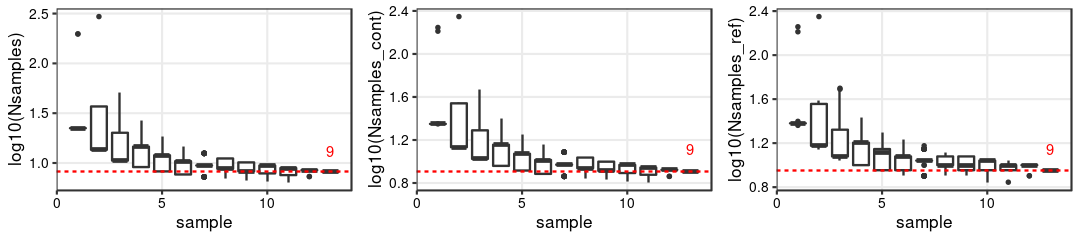

In [26]:
#Plot recommended number of samples in dependence of the number of samples used to make the prediction/recommendattion. 
#The 3 slightly different ways of calculating the recommended number of samples. Nsamples_ref is considered the most accurate one and is (internally) used in further analysis.
options(repr.plot.width = 9, repr.plot.height =2)
lim=res[sample==max(sample)]$Nsamples
lim_cont=res[sample==max(sample)]$Nsamples_cont
lim_ref=res[sample==max(sample)]$Nsamples_ref
p1=ggplot(res,aes(x=sample,y=log10(Nsamples),group=sample))+geom_boxplot(outlier.size = 0.5)+geom_hline(yintercept = log10(lim),col="red",lty=20)+annotate(geom="text",label=ceiling(lim),y=log10(lim+5),x=res[sample==max(sample)]$sample,col="red",size=3)
p2=ggplot(res,aes(x=sample,y=log10(Nsamples_cont),group=sample))+geom_boxplot(outlier.size = 0.5)+geom_hline(yintercept = log10(lim_cont),col="red",lty=20)+annotate(geom="text",label=ceiling(lim_cont),y=log10(lim_cont+5),x=res[sample==max(sample)]$sample,col="red",size=3)
p3=ggplot(res,aes(x=sample,y=log10(Nsamples_ref),group=sample))+geom_boxplot(outlier.size = 0.5)+geom_hline(yintercept = log10(lim_ref),col="red",lty=20)+annotate(geom="text",label=ceiling(lim_ref),y=log10(lim_ref+5),x=res[sample==max(sample)]$sample,col="red",size=3)
cowplot::plot_grid(p1,p2,p3,ncol = 3)

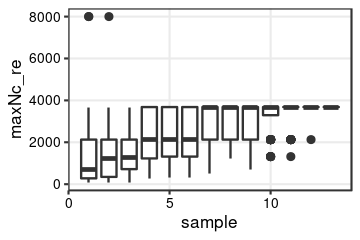

In [27]:
options(repr.plot.width = 3, repr.plot.height =2)
ggplot(res,aes(x=sample,y=maxNc_re,group=sample))+geom_boxplot()

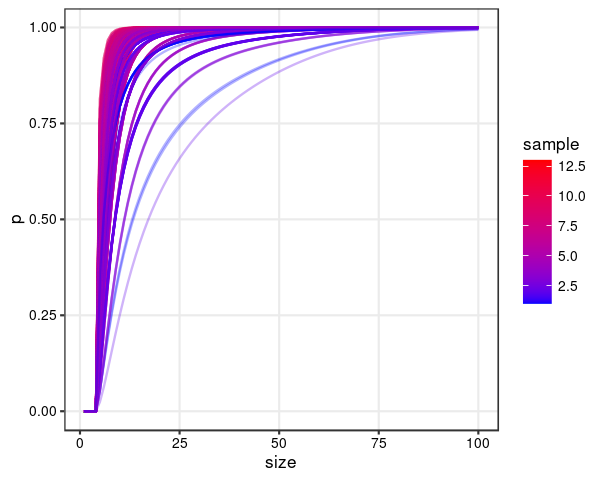

In [28]:
#Success probablility in dependence of the number of profiled samples (size), shown separately for each of the 100 rendom samplings.
options(repr.plot.width = 5, repr.plot.height =4)
ggplot(ps,aes(x=size,y=p,group=samples,col=sample))+geom_line(alpha=0.3)+scale_color_gradient(high="red",low="blue") #+facet_wrap(~sample,ncol=3)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
"Removed 391 rows containing missing values (geom_smooth)."


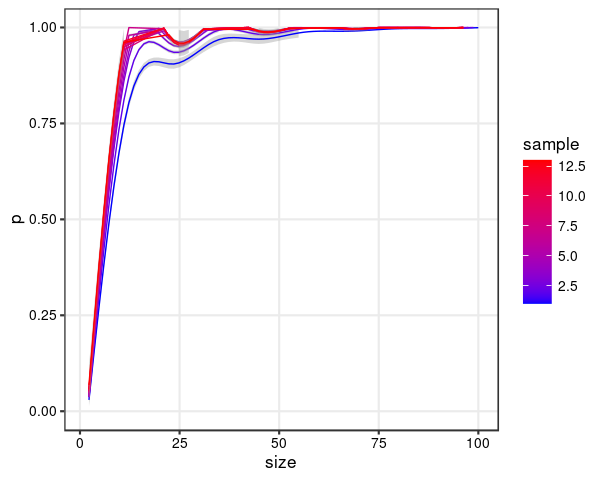

In [29]:
#Same as above but combined per number of train samples (sample)
options(repr.plot.width = 5, repr.plot.height =4)
ggplot(ps,aes(x=size,y=p,group=sample,col=sample))+geom_smooth(size=0.3)+scale_color_gradient(high="red",low="blue")+ylim(c(0,1)) #+facet_wrap(~sample,ncol=3)

#### 2.3 Validation analysis using all non-train samples as test samples (assessed across different numbers of training samples)

In [30]:
sub=cell_counts[condition=="cell"]

In [31]:
sub_t=sub[,.(Ntc=N_cells[cell_type=="T cell"],Nntc=sum(N_cells[cell_type!="T cell"])),by="name"]
sub_t[is.na(sub_t)]=0
sub_t[,f:=Ntc/Nntc,]

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



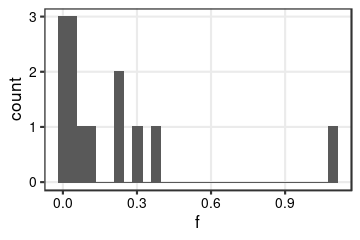

In [32]:
#Histogram of target cell frequencies
options(repr.plot.width = 3, repr.plot.height =2)
ggplot(sub_t, aes(x=f))+geom_histogram()

In [33]:
val=data.table()
val_cross=data.table()
totN=length(unique(sub$name))
for (n in 1:totN){
    ret=get_sampleN(sub,sample=n, tc = "T cell", max_cross = 1000,conf = 0.95,do.test = TRUE,same = TRUE)
    ret_cross=get_sampleN(sub,sample=n, tc = "T cell", max_cross = 1000,conf = 0.95,do.test = TRUE,same = FALSE)
    val=rbindlist(list(val,ret[[3]]))
    val_cross=rbindlist(list(val_cross,ret_cross[[3]]))
}

In [ ]:
save(val,file = paste0(out,"/validation.RData"))
save(val_cross,file = paste0(out,"/validation_cross.RData"))

In [ ]:
val[,mode:="same",]
val_cross[,mode:="cross",]
val_all=rbindlist(list(val,val_cross))

In [ ]:
head(val_all)

In [ ]:
val_comb=val_all[,.(mean_hit_rate=mean(hit_rate)),by=c("i","Nsample","train_samples","test_samples","Nc_ref","post_conf","a_test","b_test","a_train","b_train","mode")]

In [ ]:
head(val_comb)

In [ ]:
get_ct_freq=function(dat,sample_str){
    samples=unlist(strsplit(sample_str,"\\|"))
    freq=mean(dat[name%in%samples,]$f)
    zeros=sum(dat[name%in%samples,]$f==0)
    list(freq,zeros)
}

val_comb[,c("tc_f_train","tc_z_train"):=get_ct_freq(sub_t,train_samples),by=c("i","Nsample","mode")]
val_comb[,c("tc_f_test","tc_z_test"):=get_ct_freq(sub_t,test_samples),by=c("i","Nsample","mode")]
val_comb[,d_tc_f:=tc_f_train-tc_f_test,by=c("i","Nsample","mode")]
val_comb[,d_tc_z:=tc_z_train-tc_z_test,by=c("i","Nsample","mode")]

In [ ]:
options(repr.plot.width = 4, repr.plot.height =3)
ggplot(val_comb,aes(y=mean_hit_rate,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
geom_hline(yintercept=0.95,lty=20,color="black")

In [ ]:
options(repr.plot.width = 34, repr.plot.height =12)
ggplot(val_all, aes(x=hit_rate))+geom_histogram(bins = 100)+geom_vline(xintercept = 0.95,lty=20,col="red")+facet_wrap(mode~Nsample, scale="free")

In [ ]:
options(repr.plot.width = 34, repr.plot.height =12)
ggplot(val_comb, aes(x=mean_hit_rate))+geom_histogram(bins = 100)+geom_vline(xintercept = 0.95,lty=20,col="red")+facet_wrap(mode~Nsample, scale="free")

In [ ]:
options(repr.plot.width = 12, repr.plot.height =6)
ggplot(val_comb[Nsample<21&mode=="same"], aes(x=mean_hit_rate,y=post_conf))+geom_point(alpha=0.1)+facet_wrap(~Nsample)+geom_vline(xintercept = 0.95,lty=20,col="red")

In [ ]:
options(repr.plot.width = 12, repr.plot.height =6) 
ggplot(val_comb[Nsample<21&mode=="cross"], aes(x=mean_hit_rate,y=d_tc_z))+geom_point(alpha=0.1)+facet_wrap(~Nsample)+geom_vline(xintercept = 0.95,lty=20,col="red")

#### 2.4 Cross-validation is only sensible with the same number of test an training samples (--> same as 2.3 but using same number of train and test samples)

In [ ]:
sub=cell_counts[condition=="cell"]

In [ ]:
all_samples=unique(sub$name)
totN=length(unique(sub$name))
totN=floor(totN/2)
totN

In [ ]:
val=data.table()
val_cross=data.table()
for (n in 1:totN){
    ret_def<-get_sampleN(sub,sample=n,tc = "T cell", sample_same = TRUE,max_cross = 1000,conf = 0.95,do.test = TRUE)
    ret_def_same<-get_sampleN(sub,sample=n,tc = "T cell", max_cross = 1000,conf = 0.95,same = TRUE,do.test = TRUE)
    val=rbindlist(list(val,ret_def_same[[3]]))
    val_cross=rbindlist(list(val_cross,ret_def[[3]]))
}

In [ ]:
save(val,file = paste0(out,"/validation_10.RData"))
save(val_cross,file = paste0(out,"/validation_cross_10.RData"))

In [ ]:
val_cross[,mode:="cross",]
val[,mode:="same",]
val=rbindlist(list(val_cross,val))

In [ ]:
val_comb=val[,.(mean_hit_rate=mean(hit_rate)),by=c("i","Nsample","train_samples","test_samples","Nc_ref","post_conf","a_test","b_test","a_train","b_train","mode")]

In [ ]:
get_ct_freq=function(dat,sample_str){
    samples=unlist(strsplit(sample_str,"\\|"))
    freq=mean(dat[name%in%samples,]$f)
    zeros=sum(dat[name%in%samples,]$f==0)
    list(freq,zeros)
}

val_comb[,c("tc_f_train","tc_z_train"):=get_ct_freq(sub_t,train_samples),by=c("i","Nsample","mode")]
val_comb[,c("tc_f_test","tc_z_test"):=get_ct_freq(sub_t,test_samples),by=c("i","Nsample","mode")]
val_comb[,d_tc_f:=tc_f_train-tc_f_test,by=c("i","Nsample","mode")]
val_comb[,d_tc_z:=tc_z_train-tc_z_test,by=c("i","Nsample","mode")]

In [ ]:
options(repr.plot.width = 30, repr.plot.height =3.5)
ggplot(val, aes(x=hit_rate))+geom_histogram(bins = 100)+geom_vline(xintercept = 0.95,lty=20,col="red")+facet_grid(mode~Nsample)

In [ ]:
options(repr.plot.width = 4, repr.plot.height =4)
p1=ggplot(val_comb,aes(y=mean_hit_rate,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
geom_hline(yintercept=0.95,lty=20,color="black")+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())

p2=ggplot(val_comb,aes(y=Nc_ref,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)
grid.draw(rbind(ggplotGrob(p1), ggplotGrob(p2), size = "first"))
#grid.arrange(p1, p2, nrow=2)

In [ ]:
options(repr.plot.width = 30, repr.plot.height =4.5)
ggplot(val_comb, aes(x=mean_hit_rate))+geom_histogram(bins = 100)+geom_vline(xintercept = 0.95,lty=20,col="red")+facet_wrap(mode~Nsample,scale="free",nrow=2)

In [ ]:
options(repr.plot.width = 18, repr.plot.height =4)
ggplot(val_comb[mode=="cross"],aes(y=d_tc_z,x=mean_hit_rate))+geom_point(alpha=0.5)+geom_vline(xintercept = 0.95,col="red",lty=20)+facet_wrap(~Nsample,scale="free",nrow=2)

#### 2.5 Compare different cell types

In [ ]:
sub=cell_counts[condition=="cell"]

In [ ]:
sub_ct=melt(sub[,.(cts=.N,T=N_cells[cell_type=="T cell"]/sum(N_cells),B=N_cells[cell_type=="B cell"]/sum(N_cells),Malignant=N_cells[cell_type=="Malignant"]/sum(N_cells)),by="name"],id.vars = "name",na.rm = FALSE)
sub_ct[is.na(sub_ct)]=0

In [ ]:
#Target cell type frequency distributions
options(repr.plot.width = 9, repr.plot.height =2)
ggplot(sub_ct, aes(x=value))+geom_histogram()+facet_wrap(~variable,nrow=1,scale="free")

In [ ]:
# frequency of "positive samples" estimate
sub_ct[,sum(value>0.01)/.N,by="variable"]

In [ ]:
all_samples=unique(sub$name)
totN=length(unique(sub$name))
totN_half=floor(totN/2)
totN
totN_half

In [ ]:
#Specify parameters for different cell types/runs. Here also using the positive sample frequency prior: (tc,prior_sf,weight) 
cts=list(c("T cell",0.5,5),c("B cell",0.0001,5),c("Malignant",0.6,5),c("T cell",0,0),c("B cell",0,0),c("Malignant",0,0))

In [ ]:
val=data.table()
val_cross=data.table()
ps=data.table()
for (n in 1:totN){
    for (c in cts){
        ct=c[1]
        sf=as.numeric(c[2])
        w=as.numeric(c[3])
        if (n<=totN_half){
            ret_def<-get_sampleN(sub,tc = ct,prior_sf =sf ,weight = w,sample=n,sample_same = TRUE,max_cross = 100,conf = 0.95,do.test = TRUE)
            val_cross=rbindlist(list(val_cross,ret_def[[3]][,c("ct","sf","w"):=list(ct,sf,w),]))
        }
    ret_def_same<-get_sampleN(sub,tc = ct,prior_sf =sf,weight = w,sample=n,max_cross = 100,conf = 0.95,same = TRUE,do.test = TRUE)
    val=rbindlist(list(val,ret_def_same[[3]][,c("ct","sf","w"):=list(ct,sf,w),]))
    ps=rbindlist(list(ps,ret_def_same[[2]][,c("ct","sf","w"):=list(ct,sf,w),]))    
        }
}

In [ ]:
save(val,file = paste0(out,"/validation_ct.RData"))
save(val_cross,file = paste0(out,"/validation_cross_ct.RData"))
save(ps,file = paste0(out,"/success_prob_ct.RData"))

In [ ]:
load(paste0(out,"/validation_ct.RData"))
load(paste0(out,"/validation_cross_ct.RData"))

In [ ]:
val_cross[,mode:="cross",]
val[,mode:="same",]
val_all=rbindlist(list(val_cross,val))

In [ ]:
val_comb=val_all[,.(mean_hit_rate=mean(hit_rate),sd_hit_rate=sd(hit_rate),mean_Nc_h=mean(Nc_h[Nc_h<quantile(Nc_h,0.9999)]),sd_Nc_h=sd(Nc_h[Nc_h<quantile(Nc_h,0.9999)])),by=c("i","ct","Nsample","train_samples","test_samples","Nc_ref","post_conf","a_test","b_test","a_train","b_train","mode","sf","w")]

In [ ]:
options(repr.plot.width = 14, repr.plot.height =8)
p1=ggplot(val_comb,aes(y=mean_hit_rate,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
geom_hline(yintercept=0.95,lty=20,color="black")+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())+facet_wrap(w~ct, nrow=1)

p2=ggplot(val_comb,aes(y=sd_hit_rate,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())+facet_wrap(w~ct, nrow=1)

p3=ggplot(val_comb,aes(y=mean_Nc_h,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())+facet_wrap(w~ct, nrow=1,scale="free_y")

p4=ggplot(val_comb,aes(y=sd_Nc_h,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())+facet_wrap(w~ct, nrow=1,scale="free_y")

p5=ggplot(val_comb,aes(y=Nc_ref,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+facet_wrap(w~ct, nrow=1,scale="free_y")
grid::grid.draw(rbind(ggplotGrob(p1), ggplotGrob(p2),ggplotGrob(p3),ggplotGrob(p4),ggplotGrob(p5) ,size = "first"))
#grid.arrange(p1, p2, nrow=2)

In [ ]:
val_comb[Nsample%in%c(10,19,21)&mode=="same",.(nCombis=.N,median_Nc_ref=median(Nc_ref),mean_Nc_ref=mean(Nc_ref),sd_Nc_ref=sd(Nc_ref)),by=c("ct","Nsample","w")]

#### 2.6 Same as above but in a larger, more heterogenious set (now all biopsy sites are included, not only liver)

In [ ]:
sub=cell_counts[condition=="cell"]

In [ ]:
sub_ct=melt(sub[,.(cts=.N,T=N_cells[cell_type=="T cell"]/sum(N_cells),B=N_cells[cell_type=="B cell"]/sum(N_cells),Malignant=N_cells[cell_type=="Malignant"]/sum(N_cells)),by="name"],id.vars = "name",na.rm = FALSE)
sub_ct[is.na(sub_ct)]=0

In [ ]:
options(repr.plot.width = 9, repr.plot.height =2)
ggplot(sub_ct, aes(x=value))+geom_histogram()+facet_wrap(~variable,nrow=1,scale="free")

In [ ]:
sub_ct[,sum(value>0.01)/.N,by="variable"]

In [ ]:
all_samples=unique(sub$name)
totN=length(unique(sub$name))
totN_half=floor(totN/2)
totN
totN_half

In [ ]:
cts=list(c("T cell",0.7,5),c("B cell",0.05,5),c("Malignant",0.8,5),c("T cell",0,0),c("B cell",0,0),c("Malignant",0,0))

In [ ]:
val=data.table()
val_cross=data.table()
ps=data.table()
for (c in cts){
    print(c[1])
    for (n in 1:totN){
        ct=c[1]
        sf=as.numeric(c[2])
        w=as.numeric(c[3])
        if (n<=totN_half){
            ret_def<-get_sampleN(sub,tc = ct,prior_sf =sf ,weight = w,sample=n,sample_same = TRUE,max_cross = 100,conf = 0.95,do.test = TRUE)
            val_cross=rbindlist(list(val_cross,ret_def[[3]][,c("ct","sf","w"):=list(ct,sf,w),]))
        }
    ret_def_same<-get_sampleN(sub,tc = ct,prior_sf =sf,weight = w,sample=n,max_cross = 100,conf = 0.95,same = TRUE,do.test = TRUE)
    val=rbindlist(list(val,ret_def_same[[3]][,c("ct","sf","w"):=list(ct,sf,w),]))
    ps=rbindlist(list(ps,ret_def_same[[2]][,c("ct","sf","w"):=list(ct,sf,w),]))    
        }
}

In [ ]:
save(val,file = paste0(out,"/validation_ct_het.RData"))
save(val_cross,file = paste0(out,"/validation_cross_ct_het.RData"))
save(ps,file = paste0(out,"/success_prob_ct_het.RData"))

In [ ]:
load(paste0(out,"/validation_ct_het.RData"))
load(paste0(out,"/validation_cross_ct_het.RData"))

In [ ]:
val_cross[,mode:="cross",]
val[,mode:="same",]
val_all=rbindlist(list(val_cross,val))

In [ ]:
val_comb=val_all[,.(mean_hit_rate=mean(hit_rate),sd_hit_rate=sd(hit_rate),mean_Nc_h=mean(Nc_h[Nc_h<quantile(Nc_h,0.9999)]),sd_Nc_h=sd(Nc_h[Nc_h<quantile(Nc_h,0.9999)])),by=c("i","ct","Nsample","train_samples","test_samples","Nc_ref","post_conf","a_test","b_test","a_train","b_train","mode","sf","w")]

In [ ]:
options(repr.plot.width = 16, repr.plot.height =9)
p1=ggplot(val_comb,aes(y=mean_hit_rate,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
geom_hline(yintercept=0.95,lty=20,color="black")+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())+facet_wrap(w~ct, nrow=1)

p2=ggplot(val_comb,aes(y=sd_hit_rate,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())+facet_wrap(w~ct, nrow=1)

p3=ggplot(val_comb,aes(y=mean_Nc_h,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())+facet_wrap(w~ct, nrow=1,scale="free_y")

p4=ggplot(val_comb,aes(y=sd_Nc_h,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())+facet_wrap(w~ct, nrow=1,scale="free_y")

p5=ggplot(val_comb,aes(y=Nc_ref,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+facet_wrap(w~ct, nrow=1,scale="free_y")
grid::grid.draw(rbind(ggplotGrob(p1), ggplotGrob(p2),ggplotGrob(p3),ggplotGrob(p4),ggplotGrob(p5) ,size = "first"))
#grid.arrange(p1, p2, nrow=2)

In [ ]:
val_comb[Nsample%in%c(10,19,35,37)&mode=="same",.(nCombis=.N,median_Nc_ref=median(Nc_ref),mean_Nc_ref=mean(Nc_ref),sd_Nc_ref=sd(Nc_ref)),by=c("ct","Nsample","w")]

### 3 Sweep across different combinations of requeirements. --> How many samples do I need to profile if parameter 1 = x and parameter 2 = y?

In [23]:
#Out of the four requirements (minC, minS, MaxNc, conf) two are set to a constant reasonable value, while the other two are swept throug a reasonable range. 
#The recommended number of samples to be assessed is recorded and later displayed.

In [44]:
sub=cell_counts[condition=="cell"]

In [45]:
set="CS"
minCs=seq(10,200,10)
# minSs=seq(2,50,2)
minSs=seq(2,10,2)
maxNcs=8000 
confs=0.95 

In [46]:
set="NCo"
minCs=100
# minSs=10
minSs=5
maxNcs=seq(1000,10000,1000) 
confs=seq(0.7,0.98,0.02)

In [47]:
set="SCo"
minCs=100
# minSs=seq(2,50,2)
minSs=seq(2,10,2)
maxNcs=4000
confs=seq(0.7,0.98,0.02)

In [48]:
set="CCo"
minCs=seq(10,200,10)
# minSs=10
minSs=5
maxNcs=4000
confs=seq(0.7,0.98,0.02)

In [49]:
set="SN"
minCs=100
# minSs=seq(2,50,2)
minSs=seq(2,10,2)
maxNcs=seq(1000,10000,1000) 
confs=0.95

In [50]:
set="CN"
minCs=seq(10,200,10)
# minSs=10
minSs=5
maxNcs=seq(1000,10000,1000) 
confs=0.95

In [51]:
res=data.table()
ps=data.table()

In [52]:
#select one set from above, then run this block. Repeat for all sets you want to run. The results will be added (not overwritten).
for (minC in minCs){
    for (minS in minSs){
        for (maxNc in maxNcs){
            for (conf in confs){
                message('\r',paste0(minC,"/",minS,"/",maxNc,"/",conf),appendLF = FALSE)
                #ret<-get_sampleN(sub,tc = "T cell", sample=21, minC=minC,minS=minS,maxNc=maxNc,conf=conf,max_cross = 100,progress = FALSE)
                ret<-get_sampleN(sub,tc = "T cell", sample=5, minC=minC,minS=minS,maxNc=maxNc,conf=conf,max_cross = 100,progress = FALSE)
                res=rbindlist(list(res,ret[[1]][,c("minC","minS","maxNc","conf","set"):=list(minC,minS,maxNc,conf,set),]))
                ps=rbindlist(list(ps,ret[[2]][,c("minC","minS","maxNc","conf","set"):=list(minC,minS,maxNc,conf,set),]))
            }
            
        }
    }
}

10/10/1000/0.95
10/10/2000/0.95
10/10/3000/0.95
10/10/4000/0.95
10/10/5000/0.95


In [ ]:
save(res,file = paste0(out,"/param_sweep_res.RData"))
save(ps,file = paste0(out,"/param_sweep_ps.RData"))

In [ ]:
options(repr.plot.width = 15, repr.plot.height =3)
p1=ggplot(res[set=="CS"],(aes(x=minS,y=minC,fill=Nsamples_ref)))+geom_tile()+scale_fill_gradient(high="red",low="blue")
p2=ggplot(res[set=="CS"],(aes(x=minS,y=Nsamples_ref,group=minC,col=minC)))+geom_line()+scale_color_gradient(high="red",low="blue")
p3=ggplot(res[set=="CS"],(aes(x=minC,y=Nsamples_ref,group=minS,col=minS)))+geom_line()+scale_color_gradient(high="red",low="blue")
cowplot::plot_grid(p1,p2,p3,ncol=3)

In [ ]:
options(repr.plot.width = 15, repr.plot.height =3)
p1=ggplot(res[set=="NCo"],(aes(x=conf,y=maxNc,fill=Nsamples_ref)))+geom_tile()+scale_fill_gradient(high="red",low="blue")
p2=ggplot(res[set=="NCo"],(aes(x=conf,y=Nsamples_ref,group=maxNc,col=maxNc)))+geom_line()+scale_color_gradient(high="red",low="blue")
p3=ggplot(res[set=="NCo"],(aes(x=maxNc,y=Nsamples_ref,group=conf,col=conf)))+geom_line()+scale_color_gradient(high="red",low="blue")
cowplot::plot_grid(p1,p2,p3,ncol=3)

In [ ]:
options(repr.plot.width = 15, repr.plot.height =3)
p1=ggplot(res[set=="SCo"],(aes(x=conf,y=minS,fill=Nsamples_ref)))+geom_tile()+scale_fill_gradient(high="red",low="blue")
p2=ggplot(res[set=="SCo"],(aes(x=conf,y=Nsamples_ref,group=minS,col=minS)))+geom_line()+scale_color_gradient(high="red",low="blue")
p3=ggplot(res[set=="SCo"],(aes(x=minS,y=Nsamples_ref,group=conf,col=conf)))+geom_line()+scale_color_gradient(high="red",low="blue")
cowplot::plot_grid(p1,p2,p3,ncol=3)

In [ ]:
options(repr.plot.width = 15, repr.plot.height =3)
p1=ggplot(res[set=="CCo"],(aes(x=conf,y=minC,fill=Nsamples_ref)))+geom_tile()+scale_fill_gradient(high="red",low="blue")
p2=ggplot(res[set=="CCo"],(aes(x=conf,y=Nsamples_ref,group=minC,col=minC)))+geom_line()+scale_color_gradient(high="red",low="blue")
p3=ggplot(res[set=="CCo"],(aes(x=minC,y=Nsamples_ref,group=conf,col=conf)))+geom_line()+scale_color_gradient(high="red",low="blue")
cowplot::plot_grid(p1,p2,p3,ncol=3)

In [ ]:
options(repr.plot.width = 15, repr.plot.height =3)
p1=ggplot(res[set=="SN"],(aes(x=maxNc,y=minS,fill=Nsamples_ref)))+geom_tile()+scale_fill_gradient(high="red",low="blue")
p2=ggplot(res[set=="SN"],(aes(x=maxNc,y=Nsamples_ref,group=minS,col=minS)))+geom_line()+scale_color_gradient(high="red",low="blue")
p3=ggplot(res[set=="SN"],(aes(x=minS,y=Nsamples_ref,group=maxNc,col=maxNc)))+geom_line()+scale_color_gradient(high="red",low="blue")
cowplot::plot_grid(p1,p2,p3,ncol=3)

In [ ]:
options(repr.plot.width = 15, repr.plot.height =3)
p1=ggplot(res[set=="CN"],(aes(x=maxNc,y=minC,fill=Nsamples_ref)))+geom_tile()+scale_fill_gradient(high="red",low="blue")
p2=ggplot(res[set=="CN"],(aes(x=maxNc,y=Nsamples_ref,group=minC,col=minC)))+geom_line()+scale_color_gradient(high="red",low="blue")
p3=ggplot(res[set=="CN"],(aes(x=minC,y=Nsamples_ref,group=maxNc,col=maxNc)))+geom_line()+scale_color_gradient(high="red",low="blue")
cowplot::plot_grid(p1,p2,p3,ncol=3)

In [ ]:
options(repr.plot.width = 4, repr.plot.height =3)
ggplot(ps[set=="CS"],(aes(x=size,y=p,group=paste0(minC,minS),col=minS)))+geom_line(alpha=0.5)+scale_color_gradient(high="red",low="blue")
ggplot(ps[set=="SN"],(aes(x=size,y=p,group=paste0(minS,maxNc),col=maxNc)))+geom_line(alpha=0.5)+scale_color_gradient(high="red",low="blue")
ggplot(ps[set=="CN"],(aes(x=size,y=p,group=paste0(minC,maxNc),col=maxNc)))+geom_line(alpha=0.5)+scale_color_gradient(high="red",low="blue")